In [1]:
from osgeo import gdal
import sklearn as sk
import input_test_inter
import numpy as np
import tensorflow as tf
import time
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Using matplotlib backend: Qt4Agg


In [3]:
# ./modelos_clases_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_100.ckpt
batch_size = 39279/100
dropout = 0.5
n_classes = 4
epsilon=1e-08
epochs=11
c1=128
c2=256
fc=1024
b1=128
b2=256
b3=1024
decay=0.96
bands=7
epsilon=1e-08
learning_rate = 0.00001

In [4]:
dataset= input_test_inter.read_data_sets('/media/gitecx/Nuevo vol/ASIAlac/Dataset/Dataset_20x20_Clases_4',
                                   '/media/gitecx/Nuevo vol/ASIAlac/Dataset/Dataset_validation/20x20_Clases_4',
                                   bands,n_clases=n_classes)
# /media/gitecx/Nuevo vol/ASIAlac/Dataset/Dataset_11x11

39279
4364
76634


In [5]:
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], padding='VALID'),b))

def max_pool(img):
    return tf.nn.max_pool(img, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def conv_net2(images,w,b,_dropout):
    # Conv 1
    conv1 = conv2d(images,w['wc1'], b['bc1'])    
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1)
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)
    
    #Conv 2
    conv2 = conv2d(conv1, w['wc2'], b['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2)
    
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, w['wd1'].get_shape().as_list()[0]]) 
        
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, w['wd1']),b['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, w['out']),b['out'])
    return out


In [6]:
keep_prob = tf.placeholder(tf.float32) 
# tf Graph input
x = tf.placeholder(tf.float32,[None,20,20,bands])
y = tf.placeholder("float", [None, n_classes])
    
weights = {  
   # 5x5 conv, 7 input, 128 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, bands, c1])), 
     # 5x5 conv, 128 inputs, 256 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, c1, c2])), 
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*c2, fc])), 
        # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([fc, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([b1])),
    'bc2': tf.Variable(tf.random_normal([b2])),
    'bd1': tf.Variable(tf.random_normal([b3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
    }
saver = tf.train.Saver()

pred = conv_net2(x,weights,biases, keep_prob) 
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=decay,  epsilon=epsilon).minimize(cost)
#optimizer =tf.train.AdadeltaOptimizer(learning_rate=learning_rate,rho=decay, epsilon=1e-08).minimize(cost)
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
class Path:
    
    def __init__(self, folder):
        from osgeo import ogr
        self.daShapefile = folder
        # Abrir el Shapefile y tipo de archivo, leer el extent
        self.shape=ogr.GetDriverByName('ESRI Shapefile')
        self.dataSource = self.shape.Open(self.daShapefile)
        self.layer = self.dataSource.GetLayer()
        self.xmin, self.xmax, self.ymin, self.ymax = self.layer.GetExtent()
        

    def extractMatrix (self, pixel_size, pace, overlap, overSampling,):
        
        from  scipy import ndimage
        from scipy.ndimage import label
        overLap=0
        avr=80

        if(overlap > 0):
            if(overlap <= 90):
                overLap=(overlap*pace)/100
        # tamaño de los pixeles y valores sin dato

        pixel_size = 30
        NoData_value = 255 
        
        # crear data source de salida
        x_res = int((self.xmax - self.xmin) / pixel_size)
        y_res = int((self.ymax - self.ymin) / pixel_size)

        dataSource = gdal.GetDriverByName('MEM').Create('', x_res, y_res, gdal.GDT_Byte)
        dataSource.SetGeoTransform((self.xmin, pixel_size, 0, self.ymax, 0, -pixel_size))
        band = dataSource.GetRasterBand(1)
        band.SetNoDataValue(NoData_value)
        # rasterizar
        gdal.RasterizeLayer(dataSource, [1], self.layer, burn_values=[1])        
        # leer como array
        geo = dataSource.GetGeoTransform()  
        array = band.ReadAsArray()
        arraylist=[]  
        step=int(pace)    
        labeled_array, num_features = label(array)
        count=ndimage.find_objects(labeled_array)
        
        for tuples in count:   
            for l in xrange(tuples[0].start,tuples[0].stop,int(step-overLap)):
                for s in xrange(tuples[1].start,tuples[1].stop,step-overLap):
                    if(overSampling==False):                    
                        A=array[l:l+step, s:s+step]  
                        xmin=(s*pixel_size)+geo[0]
                        ymax=geo[3]-(pixel_size*l)
                        arraylist.append([xmin,ymax])
                        
        return arraylist


def maskBinary (array):

    from scipy import ndimage
    valueMin=ndimage.minimum(array)
    valueMax=ndimage.maximum(array)
    if ((valueMin ==0) | (valueMax ==255) | (valueMax ==65535) ):
        return False
    else: return True


def extractRaster(pixel_size, step,shape,model_path):
    
    a = Path(shape)
    posicion = a.extractMatrix(30,20,50, overSampling=False) 
    
    bands = []
    predictions = []
    extent=([a.xmin,a.xmax,a.ymin,a.ymax])
    raster = "/media/gitecx/Gits/Investigacion/Tuparro7/tuparro.vrt"
    ds = gdal.Open(raster)
    for i in range(ds.RasterCount):   
        band = ds.GetRasterBand(i+1)
        bands.append(band.ReadAsArray()) 

    myarray = np.asarray(bands)
    
    geo=ds.GetGeoTransform()       
    x0=geo[0]
    y0=geo[3]
    pixelwidth=geo[1]
    pixelhigh=abs(geo[5])
    width = ds.RasterXSize
    high = ds.RasterYSize    
    yi=y0-(pixelhigh*high)
    xi=x0+(pixelwidth*width)            
    
    ds = None
    

    with tf.Session() as sess :
        saver.restore(sess,model_path)
        pred_1  = tf.argmax(pred,1)
        
        print ("Model successfully restored")
        
        for i in range (len(posicion)):
        
            x = posicion[i][0]
            y = posicion[i][1]     
            xf=x+(step*pixelhigh)
            yf=y-(step*pixelhigh)

            if( (x > x0) & (xf < xi) & (y < y0) & (yf > yi)):
            
                xOffset = int((x - x0) /pixelwidth)
                yOffset = int((y - y0) / (-pixelwidth))

                x2 = xOffset + 20
                y2 = yOffset + 20
            
                patch = myarray[:,yOffset:y2,xOffset:x2].astype(float)
                t = maskBinary(patch)
                patch = np.expand_dims(patch, axis=0)
                patch = np.transpose(patch, (0, 2,3,1 ))   
                
                
                t_batch_xs, t_batch_ys,p = dataset.test.next_batch(batch_size)
                print t_batch_xs.dtype
                labels = pred_1.eval(feed_dict={x: t_batch_xs, keep_prob: 1.}, session=sess)    
                    
#                 if (t == True):  
#                     t_batch_xs, t_batch_ys,p = dataset.test.next_batch(batch_size)
#                     prediction  = tf.argmax(pred,1)
# #                     y_true = np.argmax(t_batch_ys,1)
#                     labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys,
#                                                         keep_prob: 1.}, session=sess)    
                    
#                     print labels
                   
#                 else:
#                     predictions.append([[x],[y],0])
                    

    return predictions, extent       
    

def map_out(p, extent, name):
#       extent=([a.xmin,a.xmax,a.ymin,a.ymax])

    x_min = extent[0]
    x_max = extent[1]
    y_min = extent[2]
    y_max = extent[3]
    
    y_rex = (x_max - x_min)/30
    x_rex = (y_max - y_min)/30
             
    resolution=x_res*y_res

    map_out = np.zeros(resolution).reshape(y_res,x_res)
                
            
    for i in range (len(p)):
        xOffset = abs(int((float(p[i][0][0]) - x_min) / 30))
        yOffset = abs(int((float(p[i][1][0]) - y_max) / 30))
    
        for l in range (20):
            for k in range (20):

                if(yOffset<x_res -20 and xOffset<y_res-20):
                    map_out[yOffset+k][xOffset+l]=(p[i][2]+1)    

    map_name='/home/gitecx/Documents/Maps/'+name
    print name
    plt.imshow(map_out, cmap='Dark2',  interpolation='nearest')
    np.save(map_name,map_out)



In [ ]:
pred,extent=extractRaster(30,20,"/media/gitecx/Nuevo vol/Untitled Folder/000Nueva carpeta2/iMAGNEES DE SALIDA/s_out/Final Shape's/tupa.shp",
                          '/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt')


In [8]:
def continue_training (model_path,size, size_text, ep):
    from sklearn.metrics import confusion_matrix
    with tf.Session() as sess :
        saver.restore(sess,model_path)
        print ("Model successfully restored")
        
#####################################################
#### Continue Training
#####################################################
        
        for i in range (1,int(size/batch_size)*int(epochs)):
            
            batch_xs, batch_ys,_ = dataset.train.next_batch(batch_size)
            # Fit training using batch data
            start_time = time.clock()
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
            if( i%int(size/batch_size)==0):
            
                epoch_time = time.clock()
                print "time this epoch=", (epoch_time-start_time)
                correct2 =0
                y_p = tf.argmax(pred,1)
                step = 1
                y_true_a = 0
                y_pred_a = 0
                limit = size_text/batch_size
            
######################################################
###   Continue_Testing 
######################################################
                while step <= limit:
                    t_batch_xs, t_batch_ys = dataset.test.next_batch(batch_size)
                    predictions = sess.run([correct_pred], feed_dict={x: t_batch_xs,
                                                                      y: t_batch_ys, keep_prob: 1.})
                    prediction  = tf.argmax(pred,1)
                    y_true = np.argmax(t_batch_ys,1)
                    labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys,
                                                        keep_prob: 1.}, session=sess)    
                    
                    if (step ==1):
                        y_true_a+=y_true
                        y_pred_a+=labels              
                    else:
                        y_true_a = np.concatenate((y_true_a, y_true))
                        y_pred_a = np.concatenate((y_pred_a, labels))
                    step+=1

        
                a=confusion_matrix(y_true_a, y_pred_a)            
                
                accuaracy,matrix=precision_measure(a)
                print ("test accuracy "+str(accuaracy))

        np.set_printoptions(precision=3, suppress=True)
        print (a)
        print (matrix)
        model= "./modelos_20x20_4/model_" + "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_bath_"+str(batch_size)+"_ep_"+str(ep)+".ckpt"
        save_path = saver.save(sess, model)
        print ("model saved")
        print (model)
        sess.close()

In [9]:
def precision_measure (a2):
    pro=0
    b2=a2.astype(float)

    for i in range(n_classes):
        a1=b2[i]
        sum_a1=np.sum(b2[i])
        if(sum_a1 > 0):
            b2[i]=a1/sum_a1
    #print ('Matrix de confusion con medidas de desempeño')
    np.set_printoptions(precision=3)
    for l in range (n_classes):
        if(b2[l][l]!=np.nan):
            pro+=b2[l][l]
        
    pro=pro/n_classes 
    return pro,b2

In [10]:
def test_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/100
######################################################
###   Test 
######################################################
        while step <= limit:
            t_batch_xs, t_batch_ys,p = dataset.test.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=labels              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, labels))
            step+=1
            
            for i in range(len(p)):
                
                xi=p[i].find('x=')
                yi=p[i].find('y=')
                z=p[i].find('Size')
                x0=p[i][xi+2:yi-1]
                y0=p[i][yi+2:z]

                posicion.append([[x0],[y0],labels[i]])

        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        accuaracy,matrix=precision_measure(a)
        
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)
        print (matrix)
        sess.close()
    return posicion

In [11]:
def test_model2(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
        posicion=[]
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/100
######################################################
###   Test 
######################################################
        while step <= limit:
            t_batch_xs, t_batch_ys,p = dataset.train.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=labels              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, labels))
            step+=1
            
            for i in range(len(p)):
                
                xi=p[i].find('x=')
                yi=p[i].find('y=')
                z=p[i].find('Size')
                x0=p[i][xi+2:yi-1]
                y0=p[i][yi+2:z]

                posicion.append([[x0],[y0],labels[i]])

        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        accuaracy,matrix=precision_measure(a)
        
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)
        print (matrix)
        sess.close()
    return posicion

In [12]:
def validation_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/100
        posicion=[]
######################################################
###   Test 
######################################################
        while step < limit:
            t_batch_xs, t_batch_ys,p = dataset.validation.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            pred_1 = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=pred_1              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, pred_1))
            step+=1
            
            for i in range(len(p)):
                xi=p[i].find('x=')
                
                xi=p[i].find('x=')
                yi=p[i].find('y=')
                z=p[i].find('Size')
                x0=p[i][xi+2:yi-1]
                y0=p[i][yi+2:z]

                posicion.append([[x0],[y0],pred_1[i]])
           
        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        print (a)
                       
        accuaracy,matrix=precision_measure(a)
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)        
        print (matrix)
        sess.close()
    return matrix,posicion

In [11]:
from sklearn.metrics import confusion_matrix
with tf.Session() as sess:
    sess.run(init)
    print ("Start Train")     
    
# 39279
# 4364
# 43643

##########################################################            
###   TRAIN
##########################################################
    
    # Keep training until reach max iterations
    for i in range (1,int(39279/batch_size)*int(epochs)): 
        
        batch_xs, batch_ys = dataset.train.next_batch(batch_size)
        # Fit training using batch data

        start_time = time.clock()
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
        if(i%int(39279/batch_size)==0):
            
            epoch_time = time.clock()
            print "time this epoch=", (epoch_time-start_time)
            correct2 =0
            y_p = tf.argmax(pred,1)
            step = 1
            y_true_a = 0
            y_pred_a = 0
            limit = 4364/100
######################################################
###   Test 
######################################################
            while step <= limit:
        
                t_batch_xs, t_batch_ys = dataset.test.next_batch(batch_size)
                prediction  = tf.argmax(pred,1)
                y_true = np.argmax(t_batch_ys,1)
                labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
                
                if (step ==1):
                    y_true_a+=y_true
                    y_pred_a+=labels              
                else:
                    y_true_a = np.concatenate((y_true_a, y_true))
                    y_pred_a = np.concatenate((y_pred_a, labels))
                step+=1

            a=confusion_matrix(y_true_a, y_pred_a)            
            accuaracy,matrix=precision_measure(a)
            print ("test accuracy "+str(accuaracy))
            
#######################################################   
#   END TRAIN             
############################
#           %matplotlib
#           import matplotlib.pyplot as plt
#           l=np.arange(0.0, epochs-1, 1.)
#           plt.plot(val,l, 'r--') 
    print "Optimization Finished!"    
    model= "./modelos_20x20_4/model_" + "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_Bathsize_"+str(batch_size)+".ckpt"
    np.set_printoptions(precision=3, suppress=True)
    print (a)
    print (matrix)
    save_path = saver.save(sess, model)
    print("Model saved in file: %s" % save_path)
    sess.close()        
        

Start Train
time this epoch= 0.140627
test accuracy 0.257941598159
time this epoch= 0.145022
test accuracy 0.417007448737
time this epoch= 0.147198
test accuracy 0.527703051106
time this epoch= 0.142494
test accuracy 0.609700713658
time this epoch= 0.142387
test accuracy 0.664677153832
time this epoch= 0.140544
test accuracy 0.702679470941
time this epoch= 0.14584
test accuracy 0.719766078292
time this epoch= 0.143665
test accuracy 0.745046013578
time this epoch= 0.141081
test accuracy 0.767181884109
time this epoch= 0.146521
test accuracy 0.791245859401
Optimization Finished!
[[4135    0    3   75]
 [  74 1815  642 1683]
 [  84  202 3505  425]
 [ 327    4    0 3882]]
[[ 0.981  0.     0.001  0.018]
 [ 0.018  0.431  0.152  0.399]
 [ 0.02   0.048  0.831  0.101]
 [ 0.078  0.001  0.     0.921]]
Model saved in file: ./modelos_20x20_4/model_B_7_c1_256_c2_256_fc_256_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_Bathsize_392.ckpt


# Prueba con los datos de entrenamiento las primeras 11 epocas

Model successfully restored
sklearn martix
test accuracy 0.621971093813
[[ 0.98   0.     0.     0.02 ]
 [ 0.052  0.054  0.444  0.451]
 [ 0.088  0.037  0.545  0.331]
 [ 0.077  0.004  0.009  0.91 ]]


/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


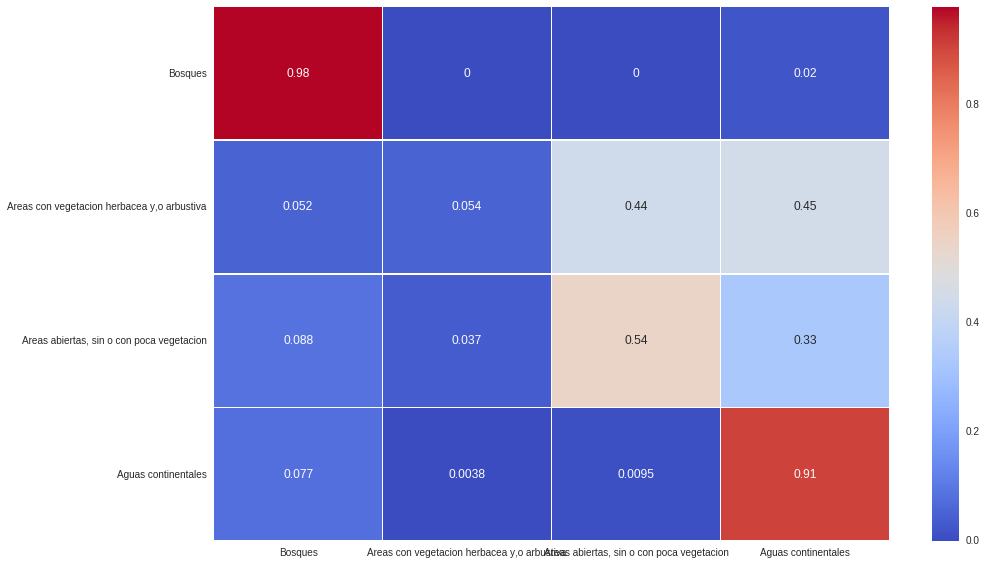

In [12]:

matrix=test_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_Bathsize_392.ckpt',
                  4364)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Validacion Primeras 11 epocas

Model successfully restored
sklearn martix
[[167445     67    113   1987]
 [   776    594  82523  34444]
 [     8      0     63     23]
 [   738      4     12  11083]]
test accuracy 0.649689384449
[[ 0.987  0.     0.001  0.012]
 [ 0.007  0.005  0.697  0.291]
 [ 0.085  0.     0.67   0.245]
 [ 0.062  0.     0.001  0.936]]


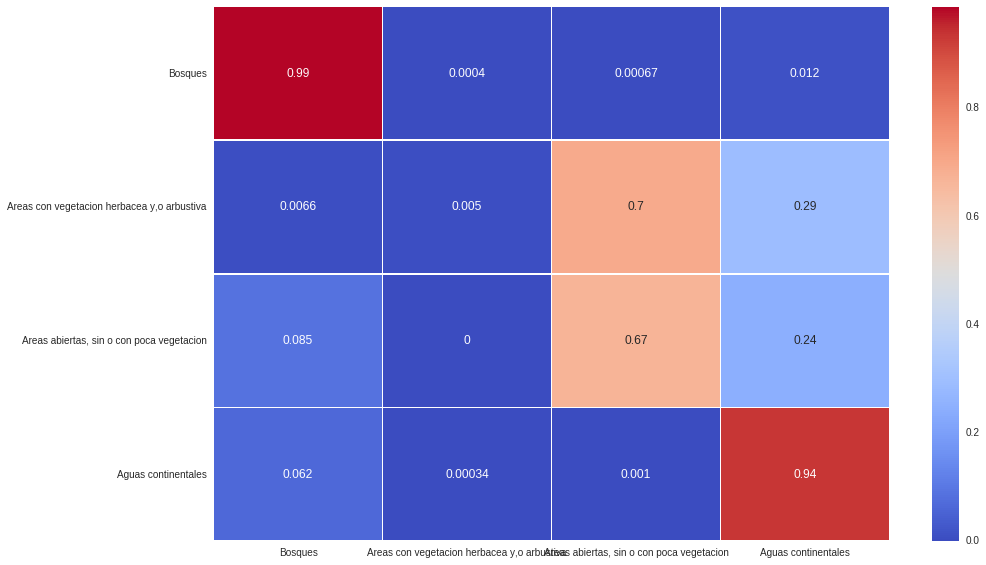

In [13]:
matrix=validation_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_Bathsize_392.ckpt', 
                        size =76634)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

In [24]:
matrix=test_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt',
                  4364)

Model successfully restored
sklearn martix
test accuracy 0.912514750973
[[ 0.979  0.     0.005  0.015]
 [ 0.032  0.861  0.084  0.023]
 [ 0.016  0.121  0.851  0.012]
 [ 0.03   0.009  0.003  0.958]]


In [ ]:
39279
4364
76634
p=validation_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt',size =76634)

In [12]:
x_min = 851378.762225
x_max = 996371.541852
y_min = 788352.912668
y_max = 905914.211906
    
x_res = int((x_max - x_min) / 30)
y_res = int((y_max - y_min) / 30)

In [32]:
def map_out(extent,p,name):
    
    x_min = extent[0]
    x_max = extent[1]
    y_min = extent[2]
    y_max = extent[3]
    
    x_res = int((x_max - x_min) / 30)
    y_res = int((y_max - y_min) / 30)
    
    resolution=x_res*y_res

    map_out = np.zeros(resolution).reshape(x_res,y_res)
    
#     import io

#     with io.FileIO("/home/gitecx/Documents/Maps/p.txt", "w") as file:
#         for i in p:
#             for l in i:
#                 file.write(l + "\n")
            
            
            
    for i in range (len(p)):
        xOffset = abs(int((float(p[i][0][0]) - x_min) / 30))
        yOffset = abs(int((float(p[i][1][0]) - y_max) / 30))
    
        for l in range (20):
            for k in range (20):
                
                if(yOffset<x_res -20 and xOffset<y_res-20):
                    map_out[yOffset+k][xOffset+l]=(p[i][2]+1)    
    map_name='/home/gitecx/Documents/Maps/'+name
    
    print name
    plt.imshow(map_out, cmap='Dark2',  interpolation='nearest')
    
    np.save(map_name,map_out)

Model successfully restored
sklearn martix
test accuracy 0.911845300817
[[ 0.98   0.002  0.003  0.015]
 [ 0.031  0.855  0.088  0.026]
 [ 0.016  0.117  0.857  0.01 ]
 [ 0.03   0.012  0.002  0.955]]
tuparro
Model successfully restored
sklearn martix
[[168020    686    253    757]
 [   629  71213  39494   6924]
 [    11     11     74      0]
 [   463      4      4  11337]]
test accuracy 0.830781283661
[[ 0.99   0.004  0.001  0.004]
 [ 0.005  0.602  0.334  0.059]
 [ 0.115  0.115  0.771  0.   ]
 [ 0.039  0.     0.     0.96 ]]


TypeError: float() argument must be a string or a number

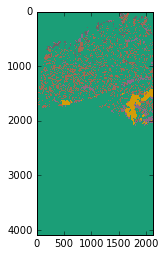

In [33]:
# xMin,yMin 905944.49,1043454.11 : xMax,yMax 1028644.09,1107237.21

extent=[ 905944.49, 1028644.09, 1043454.11, 1107237.21]
p=test_model2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt',size =76634)
map_out(extent,p,"tuparro")

# xMin,yMin 851378.76,788352.91 : xMax,yMax 996371.54,898319.65

extent=[851378.76 , 996371.54 , 788352.91 , 898319.65]
p=validation_model('/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt',size =76634)
map_out(extent,p,"Validacion")

In [42]:
%matplotlib 
plt.imshow(d,interpolation='nearest')

Using matplotlib backend: Qt4Agg


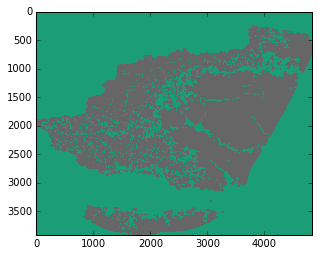

In [15]:
plt.imshow(b, cmap='Dark2',  interpolation='nearest')


In [13]:
continue_training('./media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt',
                  39279,4364,77)

InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on ./media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt: Not found: ./media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_20x20_4
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_18/_39 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_16_save_1/RestoreV2_18", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'save_1/RestoreV2', defined at:
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 498, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-926aa37dc31f>", line 35, in <module>
    saver = tf.train.Saver()
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 624, in build
    restore_sequentially, reshape)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on ./media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt: Not found: ./media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_20x20_4
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_18/_39 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_16_save_1/RestoreV2_18", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
